# Classic Solutions (NN and RNN)

## Load Data

In [1]:
import pandas as pd

splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}

df_imdb_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_imdb_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
df_imdb_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [3]:
df_imdb_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [4]:
from sklearn.model_selection import train_test_split

df_imdb_validation, df_imdb_test = train_test_split(df_imdb_test, test_size=0.2, random_state=42)
print(f"Validation set size: {len(df_imdb_validation)}")
print(f"Test set size: {len(df_imdb_test)}")

Validation set size: 20000
Test set size: 5000


## Tokenization (Create dictionary)

In [5]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = WordPieceTrainer(
    vocab_size=5000,
    min_frequency=2,
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [6]:
from tqdm import tqdm

def data_generator(texts):
    for text in tqdm(texts, desc="Train", unit=" text"):
        yield text

# Tokenizer tanítása
tokenizer.train_from_iterator(data_generator(df_imdb_train['text'].values), trainer)

Train: 100%|██████████| 25000/25000 [00:05<00:00, 4794.48 text/s]


In [7]:
tokenizer.save("tokenizer-wp-imdb.json")

In [8]:
output = tokenizer.encode(df_imdb_train["text"].values[0])
print(output.tokens)
print(output.ids)

['I', 'rented', 'I', 'A', '##M', 'C', '##U', '##R', '##I', '##OU', '##S', '-', 'Y', '##E', '##LL', '##OW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'contr', '##overs', '##y', 'that', 'surround', '##ed', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '196', '##7', '.', 'I', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'se', '##ized', 'by', 'U', '.', 'S', '.', 'c', '##ust', '##om', '##s', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'there', '##fore', 'being', 'a', 'fan', 'of', 'films', 'considered', '"', 'contr', '##overs', '##ial', '"', 'I', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.<', 'br', '/><', 'br', '/>', 'The', 'plot', 'is', 'cent', '##ered', 'around', 'a', 'young', 'Sw', '##ed', '##ish', 'drama', 'student', 'named', 'Le', '##na', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'In', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attention', '##s', 'to', 'making', 's

In [9]:
tqdm.pandas(desc="Progress")

df_imdb_train["count_of_tokens"] = df_imdb_train["text"].progress_apply(lambda x: len(tokenizer.encode(x).ids))

Progress: 100%|██████████| 25000/25000 [00:11<00:00, 2183.08it/s]


In [10]:
df_imdb_train.describe()

,label,count_of_tokens
count,25000.00000,25000.000000
mean,0.50000,352.356520
std,0.50001,272.631289
min,0.00000,11.000000
25%,0.00000,183.000000
50%,0.50000,258.000000
75%,1.00000,429.000000
max,1.00000,4142.000000


<Axes: >

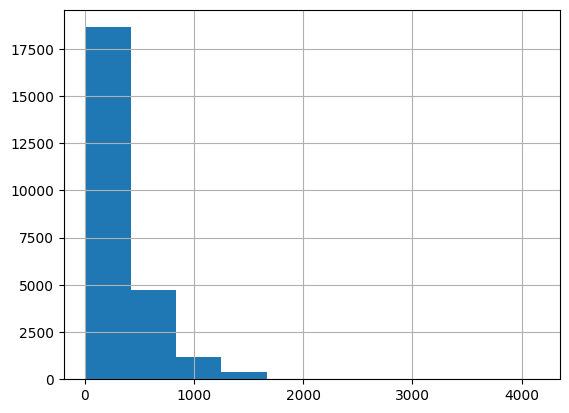

In [11]:
df_imdb_train["count_of_tokens"].hist()

In [12]:
df_imdb_test["count_of_tokens"] = df_imdb_test["text"].progress_apply(lambda x: len(tokenizer.encode(x).ids))
df_imdb_validation["count_of_tokens"] = df_imdb_validation["text"].progress_apply(lambda x: len(tokenizer.encode(x).ids))

df_imdb_train = df_imdb_train[df_imdb_train["count_of_tokens"] <= 512]
df_imdb_test = df_imdb_test[df_imdb_test["count_of_tokens"] <= 512]
df_imdb_validation = df_imdb_validation[df_imdb_validation["count_of_tokens"] <= 512]

len(df_imdb_train), len(df_imdb_test), len(df_imdb_validation)

Progress: 100%|██████████| 20000/20000 [00:09<00:00, 2195.00it/s]


(20329, 4144, 16432)

## Prepare to train

In [13]:
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("[PAD]"), pad_token="[PAD]")
tokenizer.enable_truncation(max_length=512)

In [14]:
def encode_text(texts):
    return tokenizer.encode_batch(texts)

In [15]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = encode_text(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings[idx].ids),
            'attention_mask': torch.tensor(self.encodings[idx].attention_mask)
        }
        return item, self.labels[idx]

In [35]:
from torch.utils.data import DataLoader

dataset_train = TextDataset(df_imdb_train["text"].values, df_imdb_train["label"].values)
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True)

dataset_validation = TextDataset(df_imdb_validation["text"].values, df_imdb_validation["label"].values)
dataloader_validation = DataLoader(dataset_validation, batch_size=2, shuffle=True)

dataset_test = TextDataset(df_imdb_test["text"].values, df_imdb_test["label"].values)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=True)

In [17]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Utolsó időlépés
        return self.fc(x)

In [18]:
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 128
hidden_dim = 16
output_dim = 2

vocab_size, embedding_dim, hidden_dim, output_dim

(5000, 128, 16, 2)

In [30]:
import torch.optim as optim

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [28]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    model.train()
    return accuracy

In [34]:
avg_acc = 0
pbar = tqdm(range(5))
for epoch in pbar:
  losses = []
  for batch in dataloader_train:
      inputs, labels = batch
      inputs = {key: val.to(device) for key, val in inputs.items()}
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(**inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      avg_loss = sum(losses) / len(losses)
      pbar.set_description(f"epoch: {epoch}, loss: {avg_loss:.4f}, val acc: {avg_acc:.4f}")

  avg_loss = sum(losses) / len(losses)
  avg_acc = calculate_accuracy(model, dataloader_validation, device)

  pbar.set_description(f"epoch: {epoch+1}, loss: {avg_loss:.4f}, val acc: {avg_acc:.4f}")

epoch: 4, loss: 0.3172, val acc: 0.7843: 100%|██████████| 5/5 [05:53<00:00, 70.67s/it]


In [40]:
import numpy as np

test_samples = []
true_labels = []
predicted_labels = []

random_indices = np.random.choice(len(dataset_test), size=10, replace=False)

model.eval()
with torch.no_grad():
  for i in random_indices:
    inputs, label = dataset_test[i]
    inputs = {key: val.unsqueeze(0).to(device) for key, val in inputs.items()} # Add batch dimension
    label = label.unsqueeze(0).to(device)

    outputs = model(**inputs)
    _, predicted = torch.max(outputs, 1)

    test_samples.append(dataset_test.encodings[i].tokens) # Assuming 'tokens' attribute exists
    true_labels.append(label.item())
    predicted_labels.append(predicted.item())

model.train()

for i in range(10):
  print(f"Sample {i+1}:")
  print(f"\tTokens: {test_samples[i]}")
  print(f"\tTrue Label: {true_labels[i]}")
  print(f"\tPredicted Label: {predicted_labels[i]}")

Sample 1:
	Tokens: ['Jud', '##e', 'Law', ',', 'N', '##ic', '##ole', 'Kid', '##man', ',', 'and', 'Re', '##n', '##ne', 'Z', '##el', '##w', '##ig', '##ger', '.', 'They', 'are', 'all', 'horrible', '.', 'Es', '##pecially', 'the', 'star', ',', 'Jud', '##e', 'Law', '.', '<', 'br', '/><', 'br', '/>', 'It', "'", 's', 'directed', 'by', 'the', 'same', 'guy', 'who', 'did', 'the', 'eng', '##lish', 'pat', '##ient', 'and', 'its', 'based', 'on', 'a', 'best', 'sell', '##ing', 'novel', 'of', 'a', 'man', 'ris', '##king', 'all', 'to', 'get', 'back', 'to', 'his', 'lover', 'but', 'unlike', 'the', 'wonderful', 'English', 'pat', '##e', '##int', ',', 'this', 'movie', 'sucks', '.', 'It', 'is', 'really', 'bad', '.<', 'br', '/><', 'br', '/>', 'Wor', '##st', 'dialogue', 'ever', '.', '"', 'But', 'we', "'", 've', 'only', 'know', 'each', 'other', 'for', 'a', 'moment', '"', '"', 'But', 'they', 'were', 'a', 'thous', '##and', 'moments', ',', 'like', 'di', '##am', '##ond', '##s', 'in', 'a', 'b', '##ag', '"', '##<', 'br',

In [41]:
test_accuracy = calculate_accuracy(model, dataloader_test, device)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7852316602316602
